## Sparse GP

In [1]:
!pip install gpytorch


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from linear_operator.operators import DenseLinearOperator

%matplotlib inline

Iter 50/300 - Loss: 216640.141 - Noise: 0.000000
Iter 100/300 - Loss: 78011.172 - Noise: 0.000000
Iter 150/300 - Loss: 44197.805 - Noise: 0.000000
Iter 200/300 - Loss: 26670.043 - Noise: 0.000000
Iter 250/300 - Loss: 21793.525 - Noise: 0.000000
Iter 300/300 - Loss: 18648.324 - Noise: 0.000000


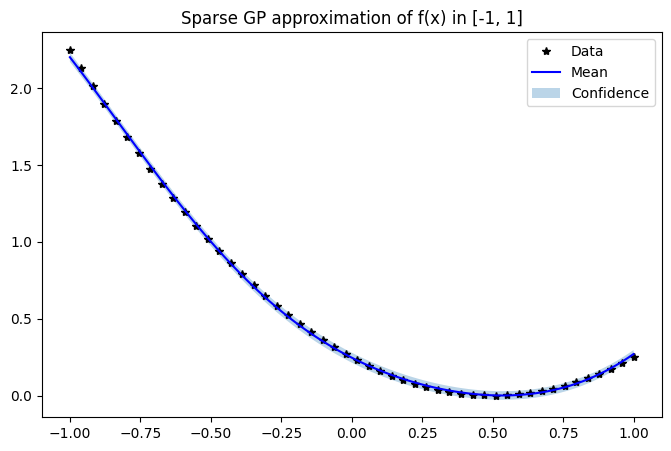

In [7]:
# 1.Define the function
def f(x):
    return (x - 0.5)**2


# 2.Generate training data in [-1, 1]
train_x = torch.linspace(-1, 1, 50)

train_y = f(train_x)

# 3.Define a Sparse GP Model
class SparseGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)


        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# 4. Choose inducing points in [-1, 1]
inducing_points = torch.linspace(-1, 1, 10)

model = SparseGPModel(inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood( noise_constraint=gpytorch.constraints.GreaterThan(1e-8))

likelihood.noise = torch.tensor(1e-8)  # very small value instead of exactly 0
likelihood.raw_noise.requires_grad = False

# 5. Training
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

training_iter = 300
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if (i+1) % 50 == 0:
        print(f'Iter {i+1}/{training_iter} - Loss: {loss.item():.3f} - Noise: {likelihood.noise.item():.6f}')
    optimizer.step()

# 6. Evaluation / prediction in [-1, 1]
model.eval()
likelihood.eval()

test_x = torch.linspace(-1, 1, 100)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

# 7. Plot results
with torch.no_grad():
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

plt.figure(figsize=(8,5))
plt.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Data')
plt.plot(test_x.numpy(), mean.numpy(), 'b', label='Mean')
plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.3, label='Confidence')
plt.title("Sparse GP approximation of f(x) in [-1, 1]")
plt.legend()
plt.show()


## Solve PDE

In [8]:

# Kernel and derivatives

def rbf(x, xp, l, var):
    # x: (N,1), xp: (M,1)
    r2 = (x - xp.T) ** 2
    return var * torch.exp(-0.5 * r2 / (l**2))

def d2_rbf_dx2(x, xp, l, var):
    # second derivative w.r.t. x (lo mismo que para xp)
    k = rbf(x, xp, l, var)
    r2 = (x - xp.T) ** 2
    l2 = l**2
    return k * (r2 / (l2**2) - 1.0 / l2)

def d2d2_rbf(x, xp, l, var):
    # d^2/dx^2 d^2/dxp^2 k(x,xp)
    k = rbf(x, xp, l, var)
    r2 = (x - xp.T) ** 2
    l2 = l**2
    return k * (r2**2 / (l2**4) - 6.0 * r2 / (l2**3) + 3.0 / (l2**2))



# task 0 = u, task 1 = u''

class DerRBFKernel(gpytorch.kernels.Kernel):
    is_stationary = True

    def __init__(self, init_lengthscale=0.4, init_variance=1.0):
        super().__init__()
        self.base_kernel = gpytorch.kernels.RBFKernel()
        self.outputscale = gpytorch.kernels.ScaleKernel(self.base_kernel)

        # Optional initialization
        self.base_kernel.lengthscale = init_lengthscale
        self.outputscale.outputscale = init_variance

    def forward(self, x1, x2, diag=False, **params):
        # x1, x2: (N,2) and (M,2) with [:,0]=location, [:,1]=task
        x1_loc = x1[:, 0:1] #primera columna (N,1)
        x2_loc = x2[:, 0:1]
        t1 = x1[:, 1].long()
        t2 = x2[:, 1].long()

        l = self.base_kernel.lengthscale
        var = self.outputscale.outputscale

        # Base and derivative blocks
        K00 = self.outputscale(x1_loc, x2_loc).to_dense() #coge el kernel y lo trnasforma en matriz
        K10 = d2_rbf_dx2(x1_loc, x2_loc, l, var)
        K01 = d2_rbf_dx2(x1_loc, x2_loc, l, var)
        K11 = d2d2_rbf(x1_loc, x2_loc, l, var)

        # Assemble according to task pairs
        #masks: (N,M)
        t1m = t1[:, None]
        t2m = t2[None, :]

        mask00=(t1m == 0) & (t2m == 0)
        mask01=(t1m == 0) & (t2m == 1)
        mask10=(t1m == 1) & (t2m == 0)
        mask11=(t1m == 1) & (t2m == 1)

        K = torch.zeros_like(K00)
        K = K + mask00*K00
        K = K + mask01*K01
        K = K + mask10*K10
        K = K + mask11*K11

        if diag:
            return torch.diag(K)

        return DenseLinearOperator(K)



# Sparse 

class SparseGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):

        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )

        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )

        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = DerRBFKernel(init_lengthscale=0.4, init_variance=1.0)

    def forward(self, x):
        mean_x = self.mean_module(x[:, 0:1])
        covar_x = self.covar_module(x, x)
        return gpytorch.distributions.MultivariateNormal(mean_x.squeeze(-1), covar_x)



# Training data

# Boundary points: u(-1)=9/4, u(1)=1/4
x_u = torch.tensor([[-1.0], [1.0]])
y_u = torch.tensor([9/4, 1/4], dtype=torch.float32)

# PDE points: u''(x) = 2
x_f = torch.linspace(-1, 1, 20).unsqueeze(-1)
y_f = 2.0 * torch.ones(x_f.shape[0], dtype=torch.float32)

# Inputs are [x, task]
Xu = torch.cat([x_u, torch.zeros_like(x_u)], dim=1)  # task=0 -> u
Xf = torch.cat([x_f, torch.ones_like(x_f)], dim=1)   # task=1 -> u''

train_x = torch.cat([Xu, Xf], dim=0)  # (22,2)
train_y = torch.cat([y_u, y_f], dim=0)  # (22,)

# Inducing points (must include both tasks)

M = 10
z_x = torch.linspace(-1, 1, M).unsqueeze(-1)

Z_u = torch.cat([z_x, torch.zeros_like(z_x)], dim=1)  # task=0
Z_f = torch.cat([z_x, torch.ones_like(z_x)], dim=1)   # task=1

inducing_points = torch.cat([Z_u, Z_f], dim=0)  # (2M, 2)


# Model and likelihood


likelihood = gpytorch.likelihoods.GaussianLikelihood( noise_constraint=gpytorch.constraints.GreaterThan(1e-8))

likelihood.noise = torch.tensor(1e-8)  # very small value instead of exactly 0
likelihood.raw_noise.requires_grad = False
model = SparseGP(inducing_points)

model.train()
likelihood.train()



# Training (Variational ELBO)


optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

mll = gpytorch.mlls.VariationalELBO(
    likelihood,
    model,
    num_data=train_y.size(0)
)

training_iter = 500
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

    if (i + 1) % 100 == 0:
        print(f"Iter {i+1}/{training_iter} - Loss: {loss.item():.3f}")



# Prediction: u(x*) (task=0)


model.eval()
likelihood.eval()

x_star = torch.linspace(-1, 1, 200).unsqueeze(-1)
X_star_u = torch.cat([x_star, torch.zeros_like(x_star)], dim=1)  # task=0 porque predecimos

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = (model(X_star_u))
    mean_u = pred.mean
    lower_u, upper_u = pred.confidence_region()



# Print learned hyperparameters


print(
    "Trained lengthscale:",
    model.covar_module.base_kernel.lengthscale.item()
)
print(
    "Trained variance:",
    model.covar_module.outputscale.outputscale.item()
)
print(
    "Noise:",
    likelihood.noise.item()
)





Iter 100/500 - Loss: 6287470.500
Iter 200/500 - Loss: 1175653.750
Iter 300/500 - Loss: 399942.281
Iter 400/500 - Loss: 201224.797
Iter 500/500 - Loss: 217193.953
Trained lengthscale: 0.6778442859649658
Trained variance: 0.6413653492927551
Noise: 9.99999993922529e-09


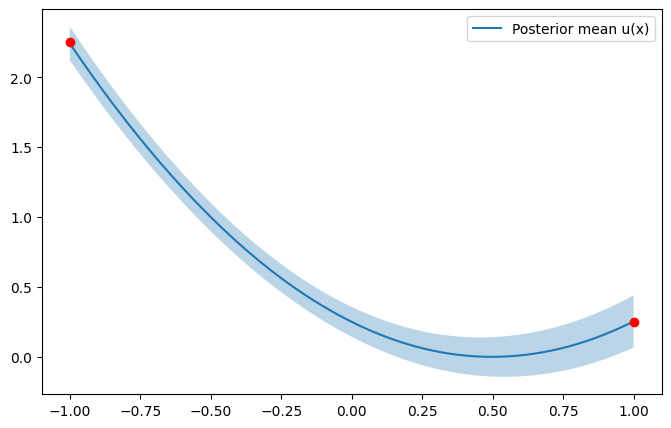

In [9]:
x = x_star.squeeze()
mean = mean_u
lower = lower_u
upper = upper_u

plt.figure(figsize=(8, 5))
plt.plot(x, mean, label="Posterior mean u(x)")
plt.fill_between(x, lower, upper, alpha=0.3)
plt.scatter(x_u.squeeze(), y_u, color="red", zorder=5)
plt.legend()
plt.show()



